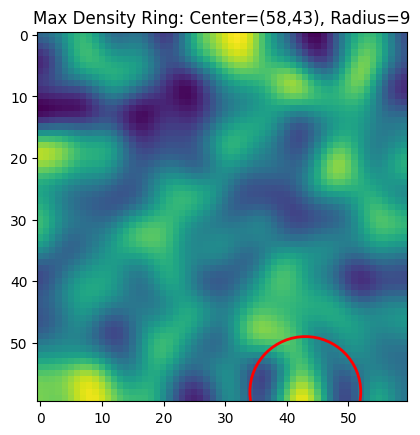

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

def generate_ring_mask(shape, r_inner, r_outer):
    """
    生成一个环形 mask
    :param shape: (H, W) 图像尺寸
    :param r_inner: 内半径
    :param r_outer: 外半径
    :return: 环形 mask (H, W)
    """
    H, W = shape
    Y, X = np.ogrid[:H, :W]
    center = (H // 2, W // 2)  # 初始假设圆心在中心
    dist_sq = (X - center[1]) ** 2 + (Y - center[0]) ** 2
    mask = (dist_sq <= r_outer ** 2) & (dist_sq > r_inner ** 2)
    return mask.astype(np.float32)

def find_max_density_ring(image, l=5, r_min=5, r_max=None):
    """
    在图像中寻找一个宽度为 l 的最大密度圆环
    :param image: 输入的灰度图 (H, W)
    :param l: 圆环的宽度
    :param r_min: 最小半径
    :param r_max: 最大半径 (默认为 min(H, W) // 2)
    :return: (cx, cy, r) 代表最佳圆环的中心坐标和半径
    """
    H, W = image.shape
    if r_max is None:
        r_max = min(H, W) // 2

    # 预处理：高斯平滑减少噪声
    image = gaussian_filter(image, sigma=1)

    # 计算累积和 (积分图像) 加速求和
    integral_image = np.cumsum(np.cumsum(image, axis=0), axis=1)

    best_density = -np.inf
    best_circle = (0, 0, 0)

    # 预计算所有可能的环形 mask
    ring_masks = {r: generate_ring_mask((H, W), r, r + l) for r in range(r_min, r_max - l)}

    # 遍历所有可能的圆心
    for cx in range(H):
        for cy in range(W):
            for r, mask in ring_masks.items():
                # 平移 mask 到当前圆心
                shifted_mask = np.roll(np.roll(mask, cx - H // 2, axis=0), cy - W // 2, axis=1)
                area = np.sum(shifted_mask)
                
                # 计算圆环密度
                if area > 0:
                    density = np.sum(image * shifted_mask) / area
                    if density > best_density:
                        best_density = density
                        best_circle = (cx, cy, r)

    return best_circle

# 生成测试数据
image = np.random.rand(60, 60)
image = gaussian_filter(image, sigma=3)  # 让数据更平滑

# 查找最大密度的圆环
cx, cy, r = find_max_density_ring(image, l=5)

# 可视化结果
fig, ax = plt.subplots()
ax.imshow(image, cmap="viridis")
circle = plt.Circle((cy, cx), r, color="red", fill=False, linewidth=2)
ax.add_patch(circle)
plt.title(f"Max Density Ring: Center=({cx},{cy}), Radius={r}")
plt.show()
